In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Caminho do arquivo (fornecido pelo sistema)
path = '../dados/base_consolidada_v2/base_final_trechos_rodovias.csv'

# Leitura
df = pd.read_csv(path).drop(columns='Unnamed: 0')

print("Dimensões iniciais da base:", df.shape)
print("\nColunas:\n", df.columns.tolist())

Dimensões iniciais da base: (2776, 22)

Colunas:
 ['codigo_trecho', 'vl_km_inic', 'vl_km_fina', 'vl_extensa', 'VMDa_C', 'VMDa_D', 'ds_sup_fed', 'GEH', 'acidentes_sem_vitima', 'acidentes_com_vitima', 'acidentes_com_mortos', 'acidentes_totais', 'UPS_medio', 'UPS_max', 'UPS_min', 'VDM', 'ICA_medio', 'ICA_max', 'ICA_min', 'tipo_pista', 'tipo_area', 'tipo_terreno']


In [10]:
df['tipo_area'].unique()

array(['Rural', nan, 'Urbana'], dtype=object)

In [11]:
pd.set_option('display.max_columns', 30)
df.head(10)

,codigo_trecho,vl_km_inic,vl_km_fina,vl_extensa,VMDa_C,VMDa_D,ds_sup_fed,GEH,acidentes_sem_vitima,acidentes_com_vitima,acidentes_com_mortos,acidentes_totais,UPS_medio,UPS_max,UPS_min,VDM,ICA_medio,ICA_max,ICA_min,tipo_pista,tipo_area,tipo_terreno
0,010BMA0370,34.0,128.8,94.8,611.0,658.0,PAV,A,1.0,5.0,2.0,8.0,10.400000,16.0,5.0,2726.0,6.233400,8.035,5.111,Simples,Rural,Plano
1,010BMA0390,128.8,156.4,27.6,2654.0,2472.0,PAV,NaN,1.0,9.0,1.0,11.0,7.375000,15.0,1.0,4669.0,5.726000,8.035,4.938,Simples,Rural,Ondulado
2,010BMA0400,156.4,176.8,20.4,1960.0,1959.0,PAV,NaN,2.0,6.0,1.0,9.0,7.500000,13.0,1.0,3892.0,5.540667,8.035,4.938,Simples,Rural,Ondulado
3,010BMA0410,176.8,203.5,26.7,2036.0,2032.0,PAV,NaN,1.0,6.0,2.0,9.0,9.500000,19.0,5.0,4042.0,5.530167,7.799,4.938,Simples,Rural,Plano
4,010BMA0420,203.5,223.1,19.6,1809.0,1817.0,PAV,NaN,0.0,4.0,2.0,6.0,9.200000,13.0,5.0,3601.0,5.007200,5.111,4.938,Simples,Rural,Ondulado
5,010BMA0430,246.4,253.6,7.2,2298.0,2340.0,PAV,NaN,10.0,45.0,10.0,65.0,20.277778,55.0,5.0,4934.0,6.481222,8.035,5.111,Simples,Rural,Plano
6,010BMA0450,260.8,295.2,34.4,2701.0,2785.0,PAV,A,10.0,68.0,2.0,80.0,15.666667,64.0,1.0,8396.0,5.613875,7.799,4.938,Simples,Rural,Ondulado
7,010BMA0460,295.2,319.8,24.6,2430.0,2323.0,PAV,NaN,2.0,9.0,4.0,15.0,9.000000,15.0,1.0,5555.0,5.090818,5.346,4.938,Simples,Rural,Plano
8,010BMA0470,319.8,378.7,58.9,1772.0,1708.0,PAV,NaN,2.0,11.0,2.0,15.0,6.916667,18.0,1.0,3355.0,5.277333,7.799,4.938,Simples,Rural,Plano
9,010BPA0490,0.0,18.0,18.0,1778.0,1718.0,PAV,NaN,2.0,13.0,2.0,17.0,13.285714,26.0,5.0,3291.0,5.896857,8.035,4.938,Simples,Rural,Ondulado


In [47]:
# Variável resposta e colunas a excluir
target = 'acidentes_com_mortos'
exclude = ['codigo_trecho', 'vl_km_inic', 'vl_km_fina', 'acidentes_com_mortos', 'acidentes_sem_vitima', 'acidentes_totais', 'UPS_medio', 'UPS_max', 'UPS_min']

missing_cols = [c for c in exclude + [target] if c not in df.columns]

In [48]:
# 1) Tratamento de nulos: resumo por coluna
null_summary = pd.DataFrame({
    'col': df.columns,
    'dtype': df.dtypes.astype(str),
    'n_null': df.isna().sum(),
    'n_unique': df.nunique(dropna=True)
}).sort_values('n_null', ascending=False)
null_summary['%null'] = null_summary['n_null']/8430
display(null_summary.head(50))

,col,dtype,n_null,n_unique,%null
codigo_trecho,codigo_trecho,object,0,2776,0.0
vl_km_inic,vl_km_inic,float64,0,2143,0.0
tipo_area,tipo_area,object,0,3,0.0
tipo_pista,tipo_pista,object,0,2,0.0
ICA_min,ICA_min,float64,0,12,0.0
ICA_max,ICA_max,float64,0,12,0.0
ICA_medio,ICA_medio,float64,0,1153,0.0
VDM,VDM,float64,0,2117,0.0
UPS_min,UPS_min,float64,0,105,0.0
UPS_max,UPS_max,float64,0,176,0.0


In [49]:
if df[target].isna().sum() > 0:
    print(f"\nRemovendo {df[target].isna().sum()} linhas com target nulo...")
    df = df[df[target].notna()].copy()

# Separe colunas numéricas e categóricas (excluindo as colunas solicitadas)
cols = [c for c in df.columns if c not in exclude]
cols = [c for c in cols if c != target]

num_cols = df[cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in cols if c not in num_cols]

print("\nVariáveis numéricas (antes do tratamento):", num_cols)
print("Variáveis categóricas (antes do tratamento):", cat_cols)

# Imputação numérica pela mediana
for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med)

# Imputação categórica com 'missing'
for c in cat_cols:
    df[c] = df[c].fillna('missing').astype(str)

# Checagem pós-imputação
post_nulls = df[cols].isna().sum().sum()
print("\nNulos restantes nas explicativas (depois da imputação):", post_nulls)


Variáveis numéricas (antes do tratamento): ['vl_extensa', 'VMDa_C', 'VMDa_D', 'acidentes_com_vitima', 'VDM', 'ICA_medio', 'ICA_max', 'ICA_min']
Variáveis categóricas (antes do tratamento): ['ds_sup_fed', 'GEH', 'tipo_pista', 'tipo_area', 'tipo_terreno']

Nulos restantes nas explicativas (depois da imputação): 0


In [50]:
# 2) Pré-processamento: dummizar categóricas, padronizar numéricas
df_dummies = pd.get_dummies(df[cat_cols], drop_first=False)
print("\nDummies criadas:", df_dummies.shape[1])

# Padronização das variáveis numéricas
scaler = StandardScaler()
df_num_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)

# Combina tudo
X = pd.concat([df_num_scaled, df_dummies], axis=1)
y = df[target].astype(int)


Dummies criadas: 18


In [51]:
# 3) Seleção de variáveis: calculo correlação de Spearman entre cada explicativa e o target
corrs = []
for col in X.columns:
    try:
        coef, p = spearmanr(X[col], y)
    except Exception as e:
        coef, p = np.nan, np.nan
    corrs.append((col, coef, p))

corr_df = pd.DataFrame(corrs, columns=['feature','spearman_r','p_value']).dropna().sort_values('spearman_r', key=abs, ascending=False)
display(corr_df.sort_values(by='p_value'))

,feature,spearman_r,p_value
3,acidentes_com_vitima,0.508816,9.938378e-183
0,vl_extensa,0.324354,5.108399e-69
7,ICA_min,-0.264507,1.161261e-45
4,VDM,0.227944,4.776664e-34
2,VMDa_D,0.226578,1.191576e-33
1,VMDa_C,0.223327,1.023914e-32
13,GEH_A,0.171522,8.988780e-20
17,GEH_missing,-0.170584,1.429245e-19
6,ICA_max,0.144167,2.305539e-14
19,tipo_pista_Simples,-0.067325,3.857574e-04


In [101]:
selected = [# 'VDM',
    # 'VMDa_C',
    # 'VMDa_D',
    # 'ICA_min',
    # 'ds_sup_fed_DUP',
    # 'tipo_pista_Simples',
    'tipo_pista_Dupla',
    # 'ds_sup_fed_PAV',
    # 'GEH_missing',
    'tipo_area_Urbana',
    # 'GEH_A',
    'vl_extensa',
    # 'tipo_area_Rural',
    # 'ICA_max',
    # 'GEH_B',
    # 'tipo_area_missing',
    # 'ICA_medio',
    # 'ds_sup_fed_IMP',
    # 'ds_sup_fed_PLA',
    # 'tipo_terreno_Plano',
    # 'ds_sup_fed_TRV',
    'tipo_terreno_Ondulado',
    # 'GEH_D',
    # 'GEH_C',
    # 'tipo_terreno_Montanhoso'
]

In [102]:
# Monta X_selected e adiciona intercepto
X_selected = X[selected].copy()
X_selected = sm.add_constant(X_selected, has_constant='add')

vars_offset = np.log(df['VDM'])

In [103]:
for coluna_str in X_selected.columns:
    if X_selected[coluna_str].dtype == 'bool':
        X_selected[coluna_str] = X_selected[coluna_str].astype('int32')

In [104]:
# 4) Ajuste do modelo de Binomial Negativa com statsmodels (GLM NegativeBinomial)
# Usamos sm.GLM com family=NegativeBinomial (muito usado para contagens sob-dispersas)
model = sm.GLM(y, X_selected, family=sm.families.NegativeBinomial(), offset=vars_offset)
result = model.fit(maxiter=100, disp=False)
print("\nResumo do modelo (negBin GLM):")
print(result.summary())


Resumo do modelo (negBin GLM):
                  Generalized Linear Model Regression Results                   
Dep. Variable:     acidentes_com_mortos   No. Observations:                 2776
Model:                              GLM   Df Residuals:                     2771
Model Family:          NegativeBinomial   Df Model:                            4
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -4445.9
Date:                  Tue, 18 Nov 2025   Deviance:                       2308.6
Time:                          22:23:57   Pearson chi2:                 2.58e+03
No. Iterations:                       8   Pseudo R-squ. (CS):             0.2224
Covariance Type:              nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

In [79]:
aic = result.aic
bic = result.bic
print("AIC:", aic)
print("BIC:", bic)

AIC: 8820.637806728088
BIC: -19713.612656601388


In [80]:
deviance = result.deviance
pearson_chi2 = result.pearson_chi2
print("Deviance:", deviance)
print("Pearson Chi²:", pearson_chi2)
print("Pearson Chi² / df:", pearson_chi2 / result.df_resid)

Deviance: 2217.35498901805
Pearson Chi²: 2544.5178253881422
Pearson Chi² / df: 0.919926907226371


In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# previsões no espaço da resposta (contagem)
y_pred = result.predict()   # importante: NÃO está no log!!

y_true = y.copy()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

In [82]:
print('mae: ', mae)
print('rmse: ', rmse)
print('smape: ', smape)

mae:  1.2461705901669105
rmse:  1.8587394150421015
smape:  1.1262620534413312


<Axes: ylabel='acidentes_com_mortos'>

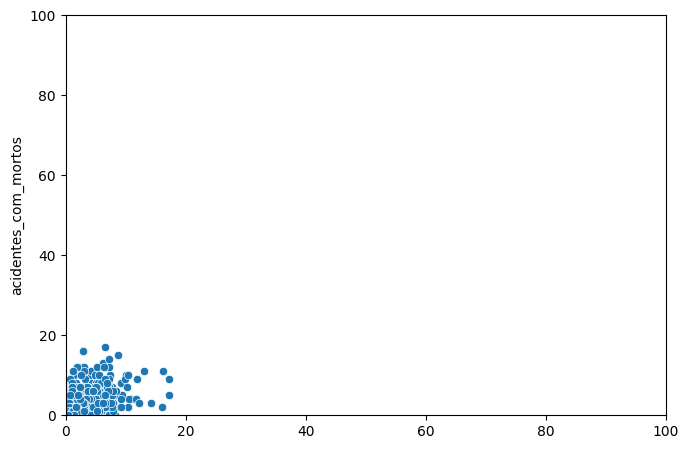

In [68]:
fig = plt.figure(figsize=(6, 4))
ax_2 = fig.add_axes([0, 0, 1, 1])

ax_2.set_xlim([0, 100])
ax_2.set_ylim([0, 100])

sns.scatterplot(x=y_pred, y=y_true)

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns

In [28]:
y.max()

368

In [33]:
import math

math.pow(27.429920, 2)

752.4005112064

In [29]:
df['acidentes_com_vitima'].describe()

count    2776.000000
mean       15.514409
std        27.429920
min         0.000000
25%         2.000000
50%         7.000000
75%        17.000000
max       368.000000
Name: acidentes_com_vitima, dtype: float64

Text(0.5, 1.0, 'Histograma quantidade acidentes com vitimas')

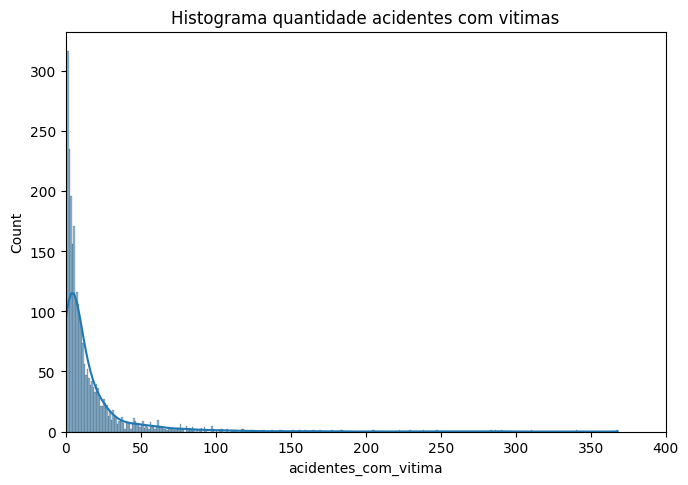

In [34]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0, 0, 1, 1])

sns.histplot(x=y, ax=ax, bins=368, kde=True)

ax.set_xlim([0, 400])
ax.set_title('Histograma quantidade acidentes com vitimas')